In [2]:
import Base.show
using DataFrames
using Random

import Pkg
#Pkg.add("Graphs")
using Graphs

#Pkg.add("Plots")
using Plots

#Pkg.add("ColorSchemes")
using ColorSchemes

using Statistics

In [3]:
mutable struct Cohesin
    processivity::Int64
    alive::Int64
    left_pos::Int64
    right_pos::Int64
    left_blocked::Bool
    right_blocked::Bool
    left_ctcf_captured::Bool
    right_ctcf_captured::Bool
    extruded_beads::Array{Bool}
    
    function Cohesin(processivity, polymer_length, alive=0)
        loading_pos = rand(1:polymer_length)
        new(processivity, alive, loading_pos, loading_pos, false, false, false, false, fill(false, polymer_length))
    end
end
    
function Base.show(io::IO, object::Cohesin) 
        left_blocked_str = string((object.left_blocked) ? " (Cohesin blocked)" : "", 
                                  (object.left_ctcf_captured) ? " (CTCF captured)" : "")
        right_blocked_str = string((object.right_blocked) ? " (Cohesin blocked)" : "", 
                                   (object.right_ctcf_captured) ? " (CTCF captured)" : "") 
        print(io, string("Lived ", object.alive, " of ", object.processivity, " - "), 
                  string("Anchors: ", object.left_pos, left_blocked_str, ", ", object.right_pos, right_blocked_str, " - "), 
                  string("Extruded beads:", findall(object.extruded_beads), "\n")) 
end


In [4]:
mutable struct Sim
    polymer_length::Int64
    bead_size::Int64
    cohesins::Array{Cohesin}
    plus_ctcfs::DataFrame
    minus_ctcfs::DataFrame
    occupied_positions::Array{Bool}
    processivity::Float64
    ctcf_capture_rate::Float64
    ctcf_stabilization_factor::Int64
    extruded_beads::Array{Bool}
    bead_graph::SimpleGraph
    
    function Sim(n, polymer_length_bp=1e6, processivity_bp=150e3, bead_size = 1e3, 
                 ctcf_capture_rate=0.25, ctcf_stabilization_factor=4, plus_ctcfs=missing,
                 minus_ctcfs=missing)
        # Define polymer_length and processity in bead units
        polymer_length = Int(polymer_length_bp/bead_size)
        processivity = processivity_bp / bead_size
        occupied_positions = fill(false, polymer_length)
        alive = 0
        cohesins = []
        bead_graph = path_graph(polymer_length)
        for i in 1:n
            collision = true
            while (collision) 
                global coh = Cohesin(processivity, polymer_length, alive)
                if (!occupied_positions[coh.left_pos])
                    collision = false
                end
            end
            occupied_positions[coh.left_pos] = true
            alive = round(alive + processivity/n)
            push!(cohesins, coh)
            add_edge!(bead_graph, coh.left_pos, copy(coh.left_pos))
        end
        empty_ctcf_df = DataFrame(pos_bp=Float64[], pos=Int64[], occupancy_rate=Float64[], bound_cohesin=Bool[])
        if ismissing(plus_ctcfs)
            plus_ctcfs = deepcopy(empty_ctcf_df)
        end
        if ismissing(minus_ctcfs)
            minus_ctcfs = deepcopy(empty_ctcf_df)
        end
        new(polymer_length, bead_size, cohesins, plus_ctcfs, minus_ctcfs, occupied_positions, 
            processivity, ctcf_capture_rate, ctcf_stabilization_factor, fill(false, polymer_length), bead_graph)            
    end
end

function Base.show(io::IO, object::Sim)
    print(io, string("Cohesin positions: ", findall(object.occupied_positions), "\n"),
              string("Extruded beads: ", sum(object.extruded_beads), " of ", object.polymer_length, "\n"),
              string("Plus CTCF positions (bound fraction): ", object.plus_ctcfs.pos_bp, 
                        "(", object.plus_ctcfs.occupancy_rate, ") ", "\n"),
              string("Minus CTCF positions (bound fraction): ", object.minus_ctcfs.pos_bp, 
                        "(", object.minus_ctcfs.occupancy_rate, ") ", "\n"), "Individual cohesins:")
    for coh in object.cohesins 
        show(coh)
    end
end

In [5]:
function add_ctcf(object::Sim, orientation, pos_bp, occupancy_rate=1) 
    if orientation=="+" 
        push!(object.plus_ctcfs, (pos_bp, ceil(pos_bp/object.bead_size), occupancy_rate, false))
        sort!(object.plus_ctcfs, :pos_bp, rev=true)
    end
    if orientation=="-"
        push!(object.minus_ctcfs, (pos_bp, ceil(pos_bp/object.bead_size), occupancy_rate, false))
        sort!(object.minus_ctcfs, :pos_bp, rev=false)
    end
    object
end

add_ctcf (generic function with 2 methods)

In [6]:
function delete_ctcf(object::Sim, pos_bp)
    idx = indexin(pos_bp, object.plus_ctcfs.pos_bp)[1]
    if idx != nothing
        delete!(object.plus_ctcfs, [idx])
    end
    idx = indexin(pos_bp, object.minus_ctcfs.pos_bp)[1]
    if idx != nothing
        delete!(object.minus_ctcfs, [idx])
    end
    object
end

delete_ctcf (generic function with 1 method)

In [7]:
function advance(object::Sim)
    occupied_positions = object.occupied_positions
    for i in 1:length(object.cohesins)
        coh = object.cohesins[i]
        coh.alive += 1
        if coh.alive >= coh.processivity
            # println("Cohesin fell off!")
            if coh.left_pos+1 != coh.right_pos
                rem_edge!(object.bead_graph, coh.left_pos, coh.right_pos)
            end
            occupied_positions[coh.left_pos] = false
            occupied_positions[coh.right_pos] = false
            # Release CTCF (if any)
            idx = indexin(coh.left_pos, object.plus_ctcfs.pos)[1]
            if idx != nothing
                object.plus_ctcfs.bound_cohesin[idx] = false
            end
            idx = indexin(coh.right_pos, object.minus_ctcfs.pos)[1]
            if idx != nothing
                object.minus_ctcfs.bound_cohesin[idx] = false
            end
            # Generate a new one (making sure it doesn't overlap an existing one)
            collision = true
            while (collision)
                coh = Cohesin(object.processivity, object.polymer_length)
                if (!occupied_positions[coh.left_pos])
                    collision = false
                end
            end
            occupied_positions[coh.left_pos] = true
            add_edge!(object.bead_graph, coh.left_pos, copy(coh.left_pos)) 
        else
            # LEFT
            new_left = coh.left_pos - 1
            if (!coh.left_ctcf_captured)
                # Left side captured by a CTCF?
                for idx in findall((object.plus_ctcfs.pos .== new_left) .& (object.plus_ctcfs.bound_cohesin .== false))
                    if rand(Float64) < object.plus_ctcfs.occupancy_rate[idx] * object.ctcf_capture_rate
                        # println("Captured!")
                        object.plus_ctcfs.bound_cohesin[idx] = true
                        coh.left_ctcf_captured = true
                        coh.processivity = object.processivity * object.ctcf_stabilization_factor
                    end
                end
                if (new_left>=1) 
                    if (occupied_positions[new_left]==false)
                        coh.left_blocked = false
                        if coh.left_pos != coh.right_pos
                            occupied_positions[coh.left_pos] = false
                        end
                        if coh.left_pos+1 != coh.right_pos
                            rem_edge!(object.bead_graph, coh.left_pos, coh.right_pos)
                        end
                        add_edge!(object.bead_graph, new_left, coh.right_pos)
                        coh.left_pos = new_left
                        occupied_positions[new_left] = true
                    end
                else
                    coh.left_blocked = true
                end
            end
            # RIGHT
            new_right = coh.right_pos + 1
            if (!coh.right_ctcf_captured)
                # Right side captured by a CTCF?
                for idx in findall((object.minus_ctcfs.pos .== new_right) .& (object.minus_ctcfs.bound_cohesin .== false))
                    if rand(Float64) < object.minus_ctcfs.occupancy_rate[idx] * object.ctcf_capture_rate
                        # println("Captured!")
                        object.minus_ctcfs.bound_cohesin[idx] = true
                        coh.right_ctcf_captured = true
                        coh.processivity = object.processivity * object.ctcf_stabilization_factor
                    end
                end
                if (new_right<=object.polymer_length)
                    if (occupied_positions[new_right]==false)
                        coh.right_blocked = false
                        if coh.left_pos != coh.right_pos
                            occupied_positions[coh.right_pos] = false
                        end
                        if coh.left_pos+1 != coh.right_pos
                            rem_edge!(object.bead_graph, coh.left_pos, coh.right_pos)
                        end
                        add_edge!(object.bead_graph, coh.left_pos, new_right)
                        coh.right_pos = new_right
                        occupied_positions[new_right] = true
                    end
                else
                    coh.right_blocked = true
                end
            end
            if coh.right_pos - coh.left_pos >= 2
                coh.extruded_beads[((coh.left_pos+1):(coh.right_pos-1))] .= true
            end
        end
        object.cohesins[i] = coh
    end
    object.occupied_positions = occupied_positions
    extruded_beads_sum = fill(false, object.polymer_length)
    for coh in object.cohesins
        extruded_beads_sum = extruded_beads_sum .| coh.extruded_beads
    end
    object.extruded_beads = extruded_beads_sum
    object
end

advance (generic function with 1 method)

In [8]:
function effective_dist(object::Sim)
    mat = transpose(dijkstra_shortest_paths(object.bead_graph, 1).dists)
    for i in 2:object.polymer_length
        mat = vcat(mat, transpose(dijkstra_shortest_paths(object.bead_graph, i).dists))
    end
    mat
end

effective_dist (generic function with 1 method)

In [26]:
function plot_fiber(object::Sim, xmin=nothing, xmax=nothing, main=nothing)
    x_list = [i for i in 1:object.polymer_length]
    y_list = map(x -> (x ? 2 : 1), object.extruded_beads)
    palette = ColorSchemes.Set1_9
    color_list = [ColorSchemes.grays[1] for i in 1:object.polymer_length]
    shape_list = [:circle for i in 1:object.polymer_length]
    for i in 1:length(object.cohesins) 
        col = palette[i]
        coh = object.cohesins[i]
        color_list[coh.left_pos] = col
        color_list[coh.right_pos] = col
        if coh.left_blocked
            shape_list[coh.left_pos] = :square
        end
        if coh.left_ctcf_captured
            shape_list[coh.left_pos] = :rtriangle
        end
        if coh.right_blocked
            shape_list[coh.right_pos] = :square
        end
        if coh.right_ctcf_captured
            shape_list[coh.right_pos] = :ltriangle
        end
    end
    if isnothing(xmin)
        xmin = (-2)
    end
    if isnothing(xmax)
        xmax = length(object.extruded_beads)+2
    end
    p = scatter(x_list, y_list, color=color_list, markershape=shape_list, label="", markersize=7, markerstrokewidth=0, 
        xlimits=(xmin,xmax), ylimits=(0,5))
    
    for i in 1:length(object.cohesins)
        col = palette[i]
        coh = object.cohesins[i]
        annotate!(mean([coh.left_pos, coh.right_pos]), 2.5+i*0.7, 
            text(string("Cohesin ", i, "\n(", coh.alive, " of ", coh.processivity, ")"), col, :center, 9))
    end
    if ((nrow(object.plus_ctcfs) + nrow(object.minus_ctcfs)) > 0 )
        ctcf_plot_df = [object.plus_ctcfs; object.minus_ctcfs]
        ctcf_plot_df.pch = [[">" for i in 1:nrow(object.plus_ctcfs)]; ["<" for i in 1:nrow(object.minus_ctcfs)]]
        ctcf_plot_df = groupby(ctcf_plot_df, :pos)
        ctcf_plot_df = combine(ctcf_plot_df, :pos, eachindex => :y, :pch)
        for i in 1:nrow(ctcf_plot_df)
            annotate!(ctcf_plot_df.pos[i], 0.25*ctcf_plot_df.y[i], text(ctcf_plot_df.pch[i], :center, 12))
        end
    end
    p
end

plot_fiber (generic function with 4 methods)

In [31]:
default(size = (900, 300))

# Test example: MYC Locus

bead 1: 127,721,000

bead size: 1,000 

CTCFS at:

    127,725,899 (bead 5) +
    
    127,734,115 (bead 14) +
    
    127,736,254 (bead 16) +
    
    127,737,853 (bead 17) +
    
    127,743,150 (bead 23) -
    
Goal: How do contacts between beads 15 and 64 change when we remove certain CTCFs?

## Step 1: Create the simulation object

    Number of cohesins = 2
    Polymer length = 70,000
    Processibity = 10,000
    Bead size = 1,000
    CTCF capture rate = 0.9
    CTCF stabilization factor = 4

In [32]:
Random.seed!(1234)
MYC_object = Sim(2, 70e3, 10e3, 1000, 0.9, 4)

Cohesin positions: [23, 39]
Extruded beads: 0 of 70
Plus CTCF positions (bound fraction): Float64[](Float64[]) 
Minus CTCF positions (bound fraction): Float64[](Float64[]) 
Individual cohesins:

Lived 0 of 10 - Anchors: 23, 23 - Extruded beads:Int64[]
Lived 5 of 10 - Anchors: 39, 39 - Extruded beads:Int64[]


In [33]:
# Add CTCFs
MYC_object = add_ctcf(MYC_object, "+", 4899, 1)
MYC_object = add_ctcf(MYC_object, "+", 13115, 1)
MYC_object = add_ctcf(MYC_object, "+", 15254, 1)
MYC_object = add_ctcf(MYC_object, "+", 16853, 1)
MYC_object = add_ctcf(MYC_object, "-", 22150, 1)

Cohesin positions: [23, 39]
Extruded beads: 0 of 70
Plus CTCF positions (bound fraction): [16853.0, 15254.0, 13115.0, 4899.0]([1.0, 1.0, 1.0, 1.0]) 
Minus CTCF positions (bound fraction): [22150.0]([1.0]) 
Individual cohesins:

Lived 0 of 10 - Anchors: 23, 23 - Extruded beads:Int64[]
Lived 5 of 10 - Anchors: 39, 39 - Extruded beads:Int64[]


## Step 2: Advance the simulation

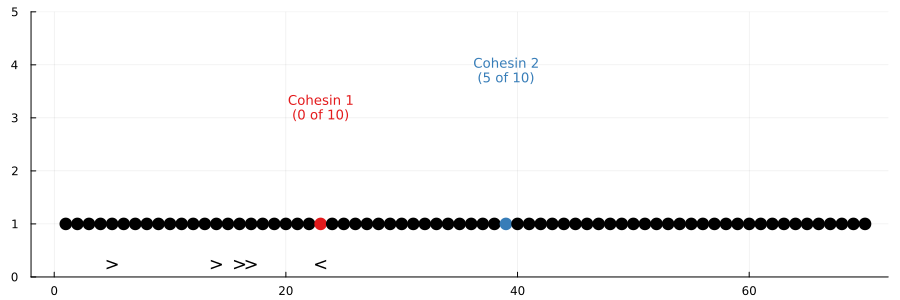

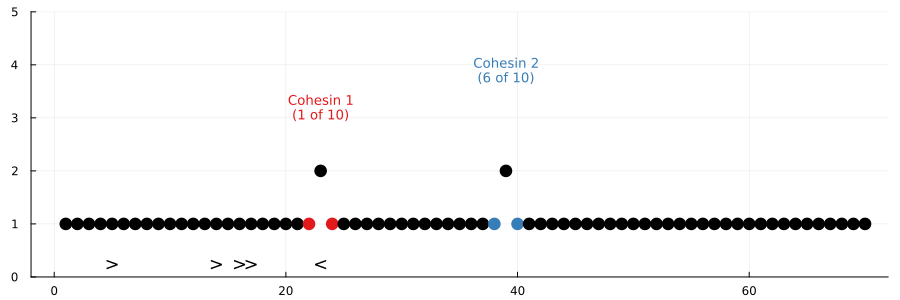

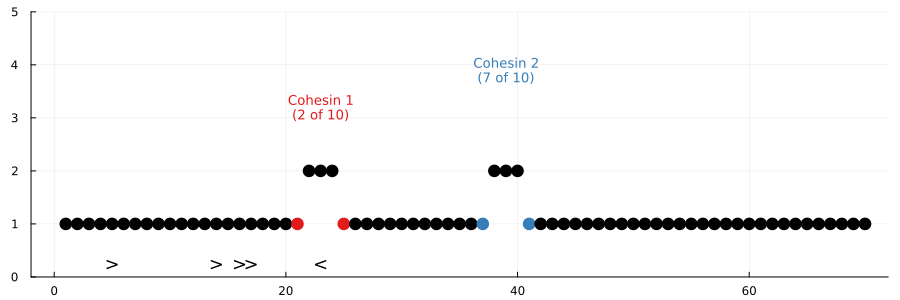

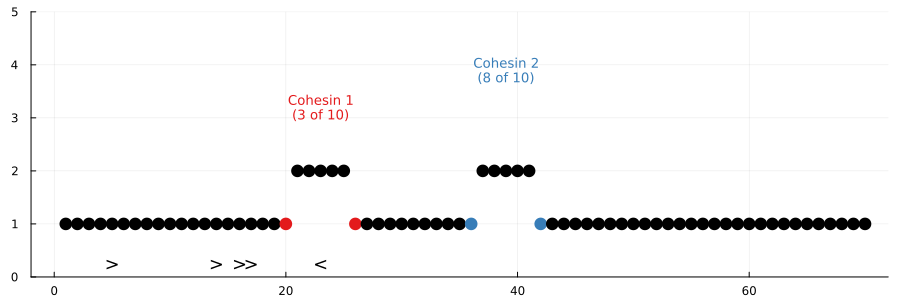

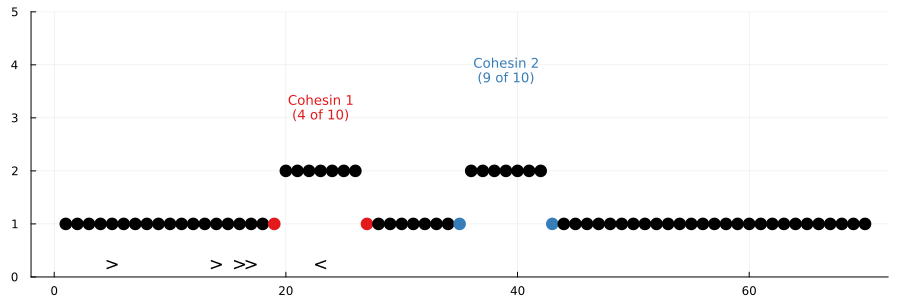

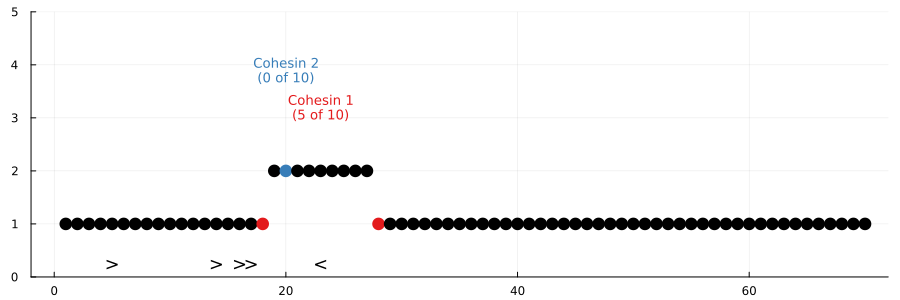

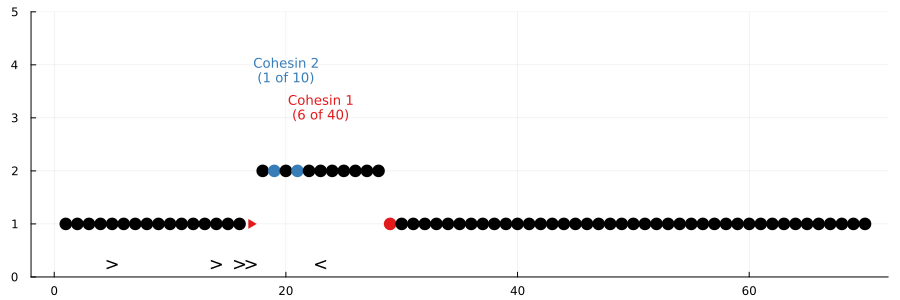

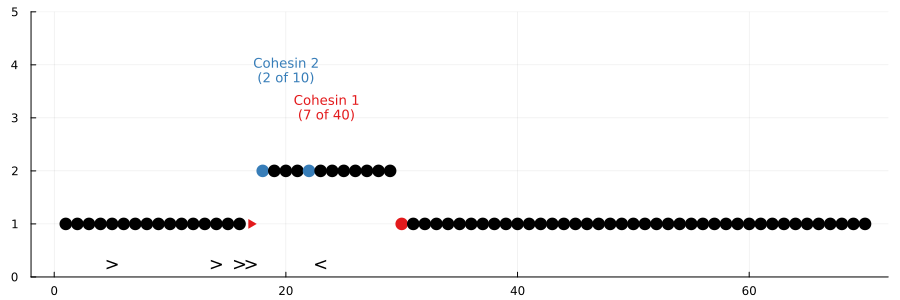

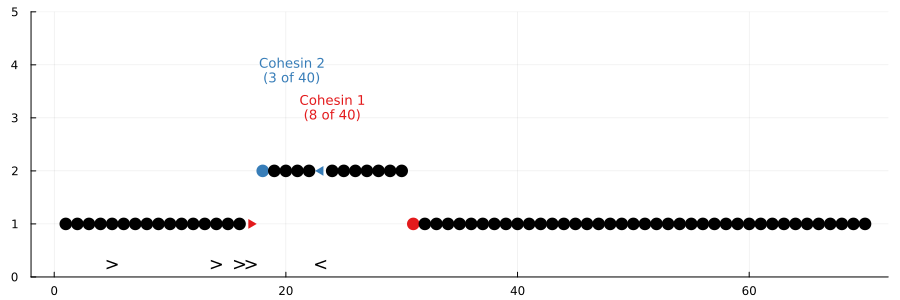

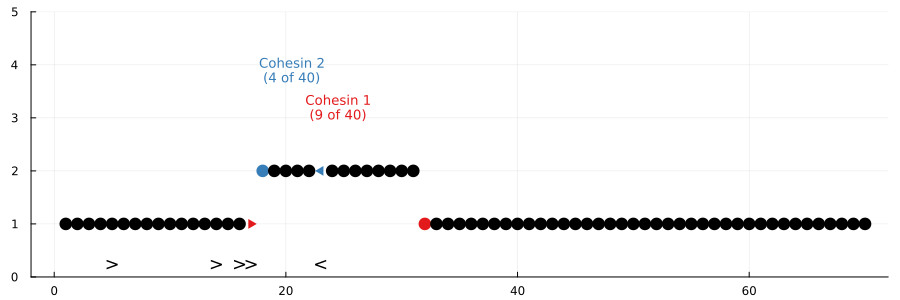

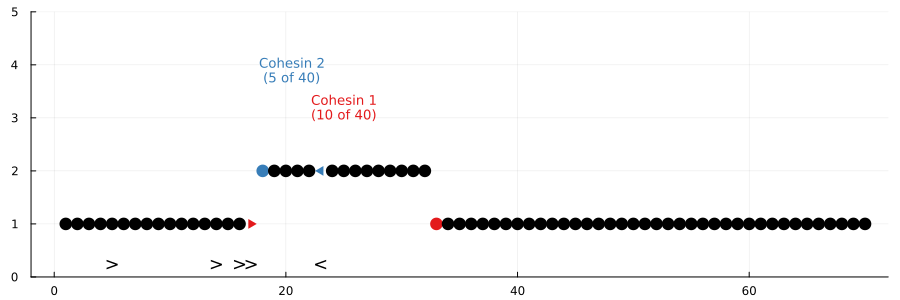

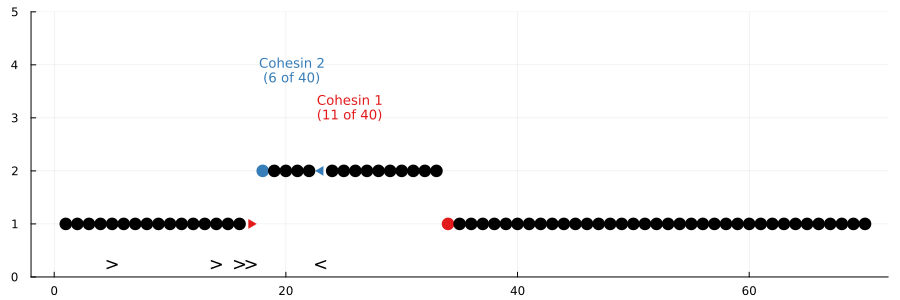

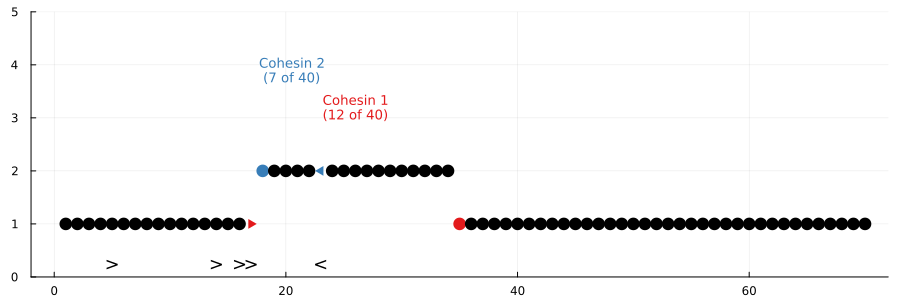

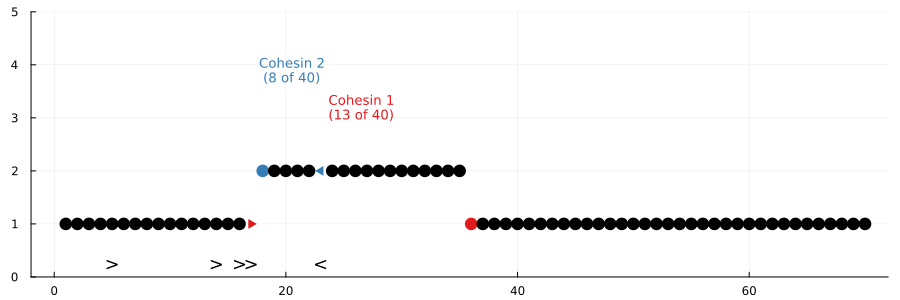

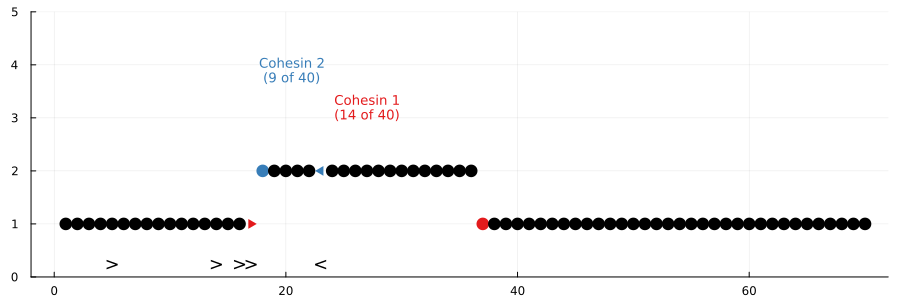

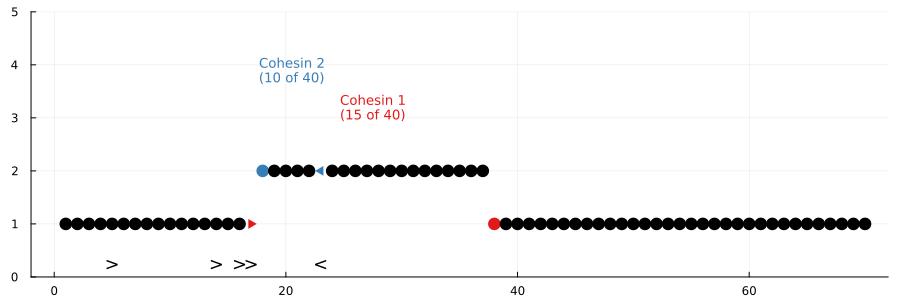

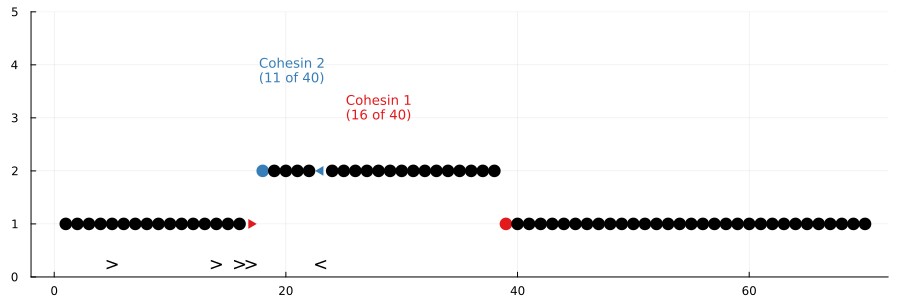

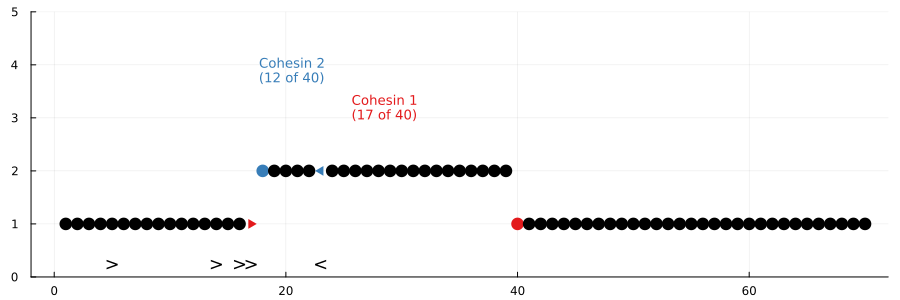

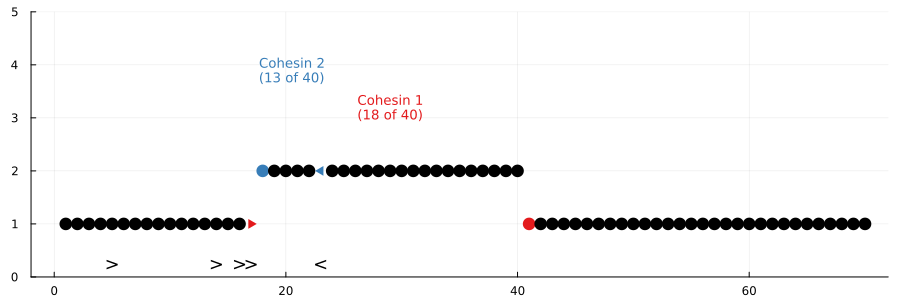

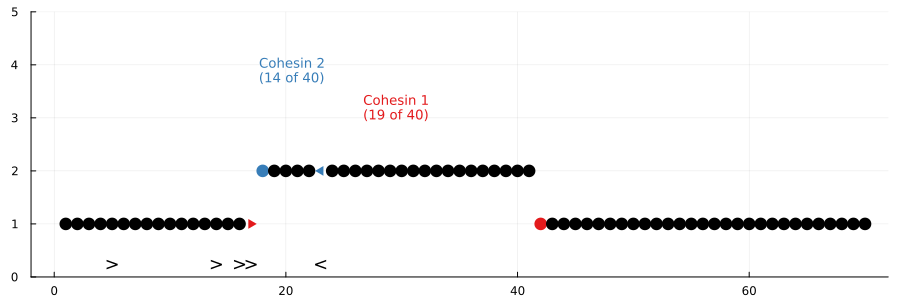

70×70 Matrix{Float64}:
 0.1        0.0909091  0.0833614  …  0.018681   0.0183843  0.018096
 0.0909091  0.1        0.0909091     0.0190055  0.0186978  0.0183992
 0.0833614  0.0909091  0.1           0.0193524  0.0190325  0.0187224
 0.0771514  0.083347   0.0909091     0.0197206  0.0193873  0.0190647
 0.0718208  0.0769982  0.0833432     0.0201128  0.019765   0.0194286
 0.0672646  0.0716201  0.0769565  …  0.0202064  0.0198576  0.0195203
 0.0633604  0.0670418  0.0715312     0.020309   0.0199586  0.0196196
 0.059953   0.0631139  0.0669133     0.0204315  0.0200783  0.0197367
 0.0569494  0.0597028  0.0629735     0.0205809  0.0202235  0.0198779
 0.0543126  0.0567523  0.0596176     0.0207646  0.0204012  0.0200499
 0.0519925  0.054191   0.0567502  …  0.0210433  0.0206688  0.0203073
 0.0501942  0.0522315  0.054584      0.0213652  0.0209774  0.0206036
 0.0487026  0.0506165  0.0528226     0.0217323  0.021329   0.0209409
 ⋮                                ⋱                        
 0.0220667  0.0225335

In [34]:
# Keep track of average effective distance between each pair of beads
dists = effective_dist(MYC_object)

# Keep track of average contacts between each pair of beads
contacts = (effective_dist(MYC_object).+10).^(-1)

# Keep track of effective distance between beads 15 and 64 at each step
a=15
b=64
dists_a_to_b = [effective_dist(MYC_object)[a,b]]

# We will advance the simulation 20,000 steps
for i in 1:20000
    # plot the first 20 steps in the simulation
    if i<=20
        display(plot_fiber(MYC_object))
    end
    advance(MYC_object)
    dists = dists + effective_dist(MYC_object)
    contacts = contacts + ((effective_dist(MYC_object).+10).^(-1))
    dists_a_to_b = push!(dists_a_to_b, effective_dist(MYC_object)[a,b])
end
dists = dists/20001
contacts = contacts/20001

## Step 3: Re-run the simulation without CTCFs at beads 14 and 16

In [36]:
Random.seed!(1234)
MYC_object2 = Sim(2, 70e3, 10e3, 1000, 0.9, 4)
MYC_object2 = add_ctcf(MYC_object2, "+", 4899, 1)
MYC_object2 = add_ctcf(MYC_object2, "+", 16853, 1)
MYC_object2 = add_ctcf(MYC_object2, "-", 22150, 1)

dists2 = effective_dist(MYC_object2)
contacts2 = (effective_dist(MYC_object2).+10).^(-1)

a=15
b=64
dists_a_to_b2 = [effective_dist(MYC_object2)[a,b]]

for i in 1:20000
    advance(MYC_object2)
    dists2 = dists2 + effective_dist(MYC_object2)
    contacts2 = contacts2 + ((effective_dist(MYC_object2).+10).^(-1))
    dists_a_to_b2 = push!(dists_a_to_b2, effective_dist(MYC_object2)[a,b])
end
dists2 = dists2/20001
contacts2 = contacts2/20001

70×70 Matrix{Float64}:
 0.1        0.0909091  0.0833617  …  0.0178476  0.017587   0.0173328
 0.0909091  0.1        0.0909091     0.0181419  0.0178721  0.0176094
 0.0833617  0.0909091  0.1           0.0184586  0.0181787  0.0179064
 0.0772     0.0833489  0.0909091     0.0187935  0.0185027  0.01822
 0.0718412  0.0769881  0.0833432     0.0191496  0.0188469  0.0185528
 0.0672975  0.0716221  0.0769594  …  0.0191393  0.0188388  0.0185467
 0.0633893  0.0670462  0.0715312     0.0191389  0.0188398  0.0185492
 0.0599744  0.0631239  0.0669297     0.019153   0.0188547  0.0185648
 0.0569563  0.0597088  0.063005      0.0191833  0.0188849  0.018595
 0.0542652  0.0567125  0.0596164     0.0192335  0.0189341  0.0186432
 0.0518801  0.0540915  0.0566958  …  0.0193491  0.0190454  0.0187507
 0.0499935  0.0520443  0.0544442     0.0194994  0.01919    0.0188901
 0.0484344  0.0503524  0.0526044     0.0196866  0.01937    0.0190635
 ⋮                                ⋱                        
 0.0208155  0.021226   

## Step 4: Compare results

Lets first look at average log-contacts between each pair of beads.

First when CTCFs at beads 14 and 16 are included:

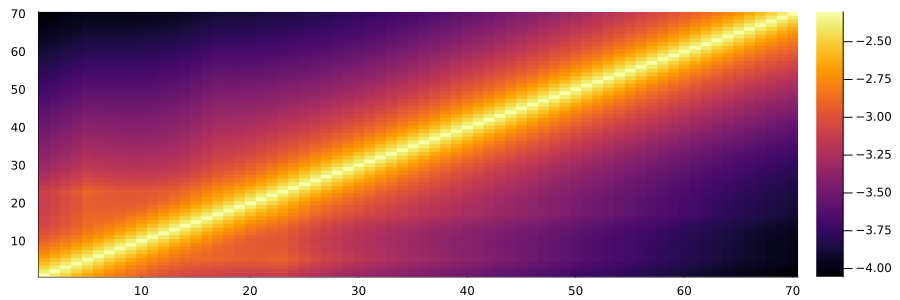

In [37]:
plot(heatmap(log.(contacts)))

And now when CTCFs at beads 14 and 16 are removed:

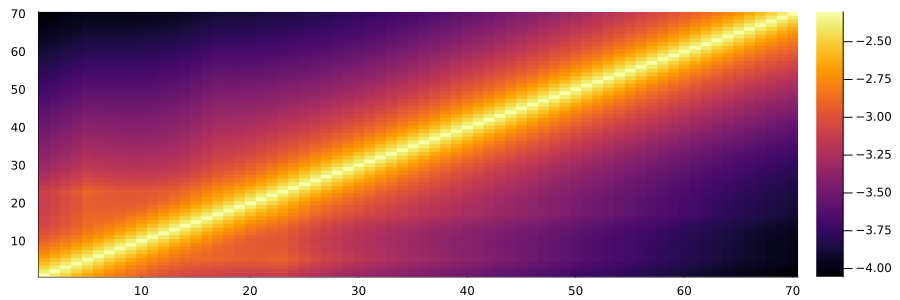

In [38]:
plot(heatmap(log.(contacts2)))

The heatmaps look fairly similar. Now, let's compare average effective distance between bead 15 and every other bead:

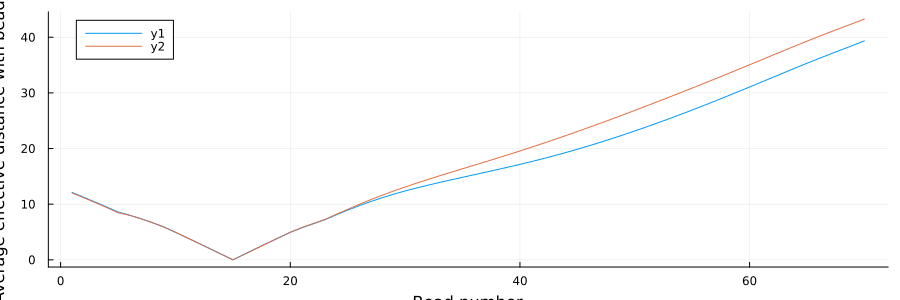

In [68]:
plot(dists[15,:])
plot!(dists2[15,:])
xlabel!("Bead number")
ylabel!("Average effective distance with bead 15")

The average effective distance between bead 15 and beads ~30-70 is smaller when CTCFs at beads 14 and 16 are included. 
Let's compare the distributions of effective distance between beads 15 and 64.

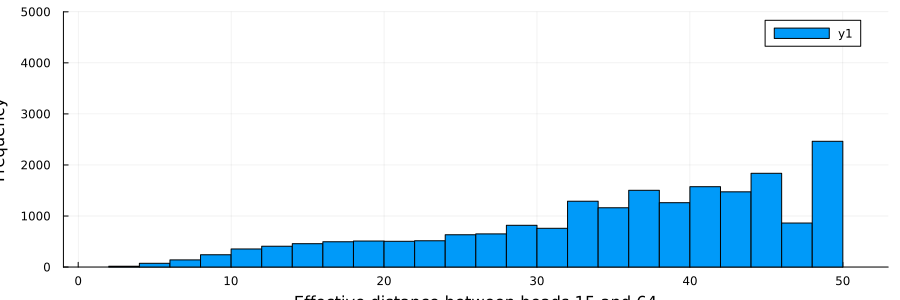

In [69]:
histogram(dists_a_to_b, bins=25)
ylims!(0, 5000)
xlabel!("Effective distance between beads 15 and 64")
ylabel!("Frequency")

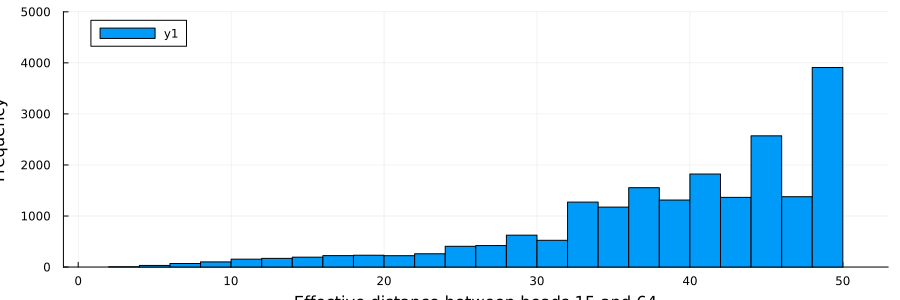

In [70]:
histogram(dists_a_to_b2, bins=25)
ylims!(0, 5000)
xlabel!("Effective distance between beads 15 and 64")
ylabel!("Frequency")

The effective distance between beads 15 and 64 is more frequently larger when CTCFs 14 and 16 are left out than when they are included.

Next Steps:   

time to run: compare against r code